# Analyse intra molecular hydrogen bonds

In [7]:
# reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from analysis import *
import matplotlib.pyplot as plt
import mdtraj
import os
import sys
sys.path.append('../')

# make imports for inset
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from Simulation.helper_functions import SOLVENT_DICT as solvent_dict
from Simulation.helper_functions import load_traj

plot_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/manuscript/Plots/"
store_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/intermediary_results/"


### Pseudo membered rings

In [3]:
id_to_smiles_dict = {0:'COCCO',1:'COCCCO',2:'COCCCCO'}
gnn_solvents = "tip3p Chloroform Methanol DMSO DMPU Diethylether Ethanol DMF DCM Toluol Benzol Hexan acetonitrile acetone aceticacid 14dioxane nitrobenzol HMPA MTBE IPA Hexafluorobenzene pyridine THF Ethylacetate Sulfolane nitromethane Butylformate Octanol cyclohexane glycerin carbontetrachloride DME 2Nitropropane Trifluorotoluene hexafluroacetone Propionitrile Benzonitrile oxylol".split(" ")
num_solvents = len(gnn_solvents)

In [4]:
num_solvents

38

In [5]:
# Mark missing datapoints
additional_submission_string = """
Run failed simulations again
"""

In [6]:
# Choose system
id = 0

In [ ]:
folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/trajectories/intra_molecular_hbond2/"

solvent_names = solvent_dict.keys()
explicit_trajs = {}

for sn in solvent_names:
    if sn == "tip3p":
        for seed in [1613111,1613112,1613113]:
            try:
                traj = mdtraj.load(f'{folder}/intra_molecular_hbond2_id_%i_openff200_tip3p_0_%i_output_stripped.h5' % (id,seed))
                assert traj.n_frames == 250000
                if seed == 1613111:
                    explicit_trajs[sn] = traj
                else:
                    explicit_trajs[sn] += traj
            except Exception as e:
                print(e)
                print(sn,seed)
    else:
        for seed in [1613111,1613112,1613113]:
            try:
                if os.path.isfile(f'{folder}/intra_molecular_hbond2{sn}{seed}_id_%i_openff200_%s_0_%i_output_stripped.h5' % (id, solvent_dict[sn]["SMILES"],seed)):
                    traj = mdtraj.load(f'{folder}/intra_molecular_hbond2{sn}{seed}_id_%i_openff200_%s_0_%i_output_stripped.h5' % (id, solvent_dict[sn]["SMILES"],seed))
                else:
                    traj = mdtraj.load(f'{folder}/intra_molecular_hbond2_id_%i_openff200_%s_0_%i_output_stripped.h5' % (id, solvent_dict[sn]["SMILES"],seed))
                assert traj.n_frames == 250000
                if seed == 1613111:
                    explicit_trajs[sn] = traj
                else:
                    explicit_trajs[sn] += traj
            except Exception as e:
                print(e)
                print(sn,seed)
                additional_submission_string += f"""
sbatch -n 8 --gpus=rtx_3090:1 --time=24:00:00  --mem-per-cpu=2000 -o simulation/slurm_log/additional_simulations_{sn}_{seed}.out --wrap='python run_simulation_for_small_molecules.py -id {id} -n 500 -f simulation_smiles/intra_molecular_hbond2.txt -s "{sn}" -r '{seed}' -a "{sn}{seed}" '"""

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [8]:
print(additional_submission_string)


Run failed simulations again



In [ ]:
file_location = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/trajectories/intra_molecular_hbond2_multi_10_all_solvent_run_seed_1612/"

gnn_trajs = {}
traj_s = load_parallel_traj(file_location + "intra_molecular_hbond2_id_%i_openff200_vacuum_plus_GNN3_vap_0_0_output.h5" % id,num_solvents*10)
print("loaded traj")
for i, s in enumerate(gnn_solvents):
    gnn_trajs[s] = [traj_s[j*num_solvents+i] for j in range(len(traj_s)//num_solvents)]
    for j in range(len(traj_s)//num_solvents):
        traj_s[j*num_solvents+i] = None
del traj_s

loaded traj


In [ ]:
file_location = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/trajectories/intra_molecular_hbond2_multi_10_NMP_solvent_run_seed_1612/"
gnn_trajs["NMP"] = load_parallel_traj(f"{file_location}intra_molecular_hbond2_id_{id}_openff200_vacuum_plus_GNN3_vap_0_0_output.h5",10)

In [11]:
## Check completnes
for sn in solvent_names:
    try:
        assert explicit_trajs[sn].n_frames == 750000
    except:
        print(sn, explicit_trajs[sn].n_frames)

In [9]:
pair_dict = {0:('O1','H8'),1:('O1','H10'),2:('O1','H12')}
align_shift_dict = {0:None,1:0.47,2:0.52}

In [10]:
norm = plt.Normalize(vmin=0, vmax=80)

In [16]:
def plot_colorbar(ax,cmap,label):
    norm = plt.Normalize(vmin=0, vmax=80)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.set_label(label)

align_shifts_to = align_shift_dict[id]
nbins = 100

def plot_ref_plus_pre(ax,ref,pre,solvent_name,align_shifts_to=None,zorder=1,linewidth=1.5):

    plot_free_energy(ax, ref, nbins, label=solvent_name + ' (ref)', color=get_sd(solvent_name), range=(0,0.7),linestyle='--',align_shifts_to=align_shifts_to,zorder=zorder,linewidth=linewidth)
    plot_free_energy(ax, pre, nbins, label=solvent_name, color=get_sd(solvent_name), range=(0,0.7),align_shifts_to=align_shifts_to,zorder=zorder,linewidth=linewidth)

def get_sd(solvent_name):
    sd = solvent_dict[solvent_name]["dielectric"]
    return cm.RdBu(sd/80)

In [22]:
# set figure text size
plt.rcParams.update({'font.size': 16})

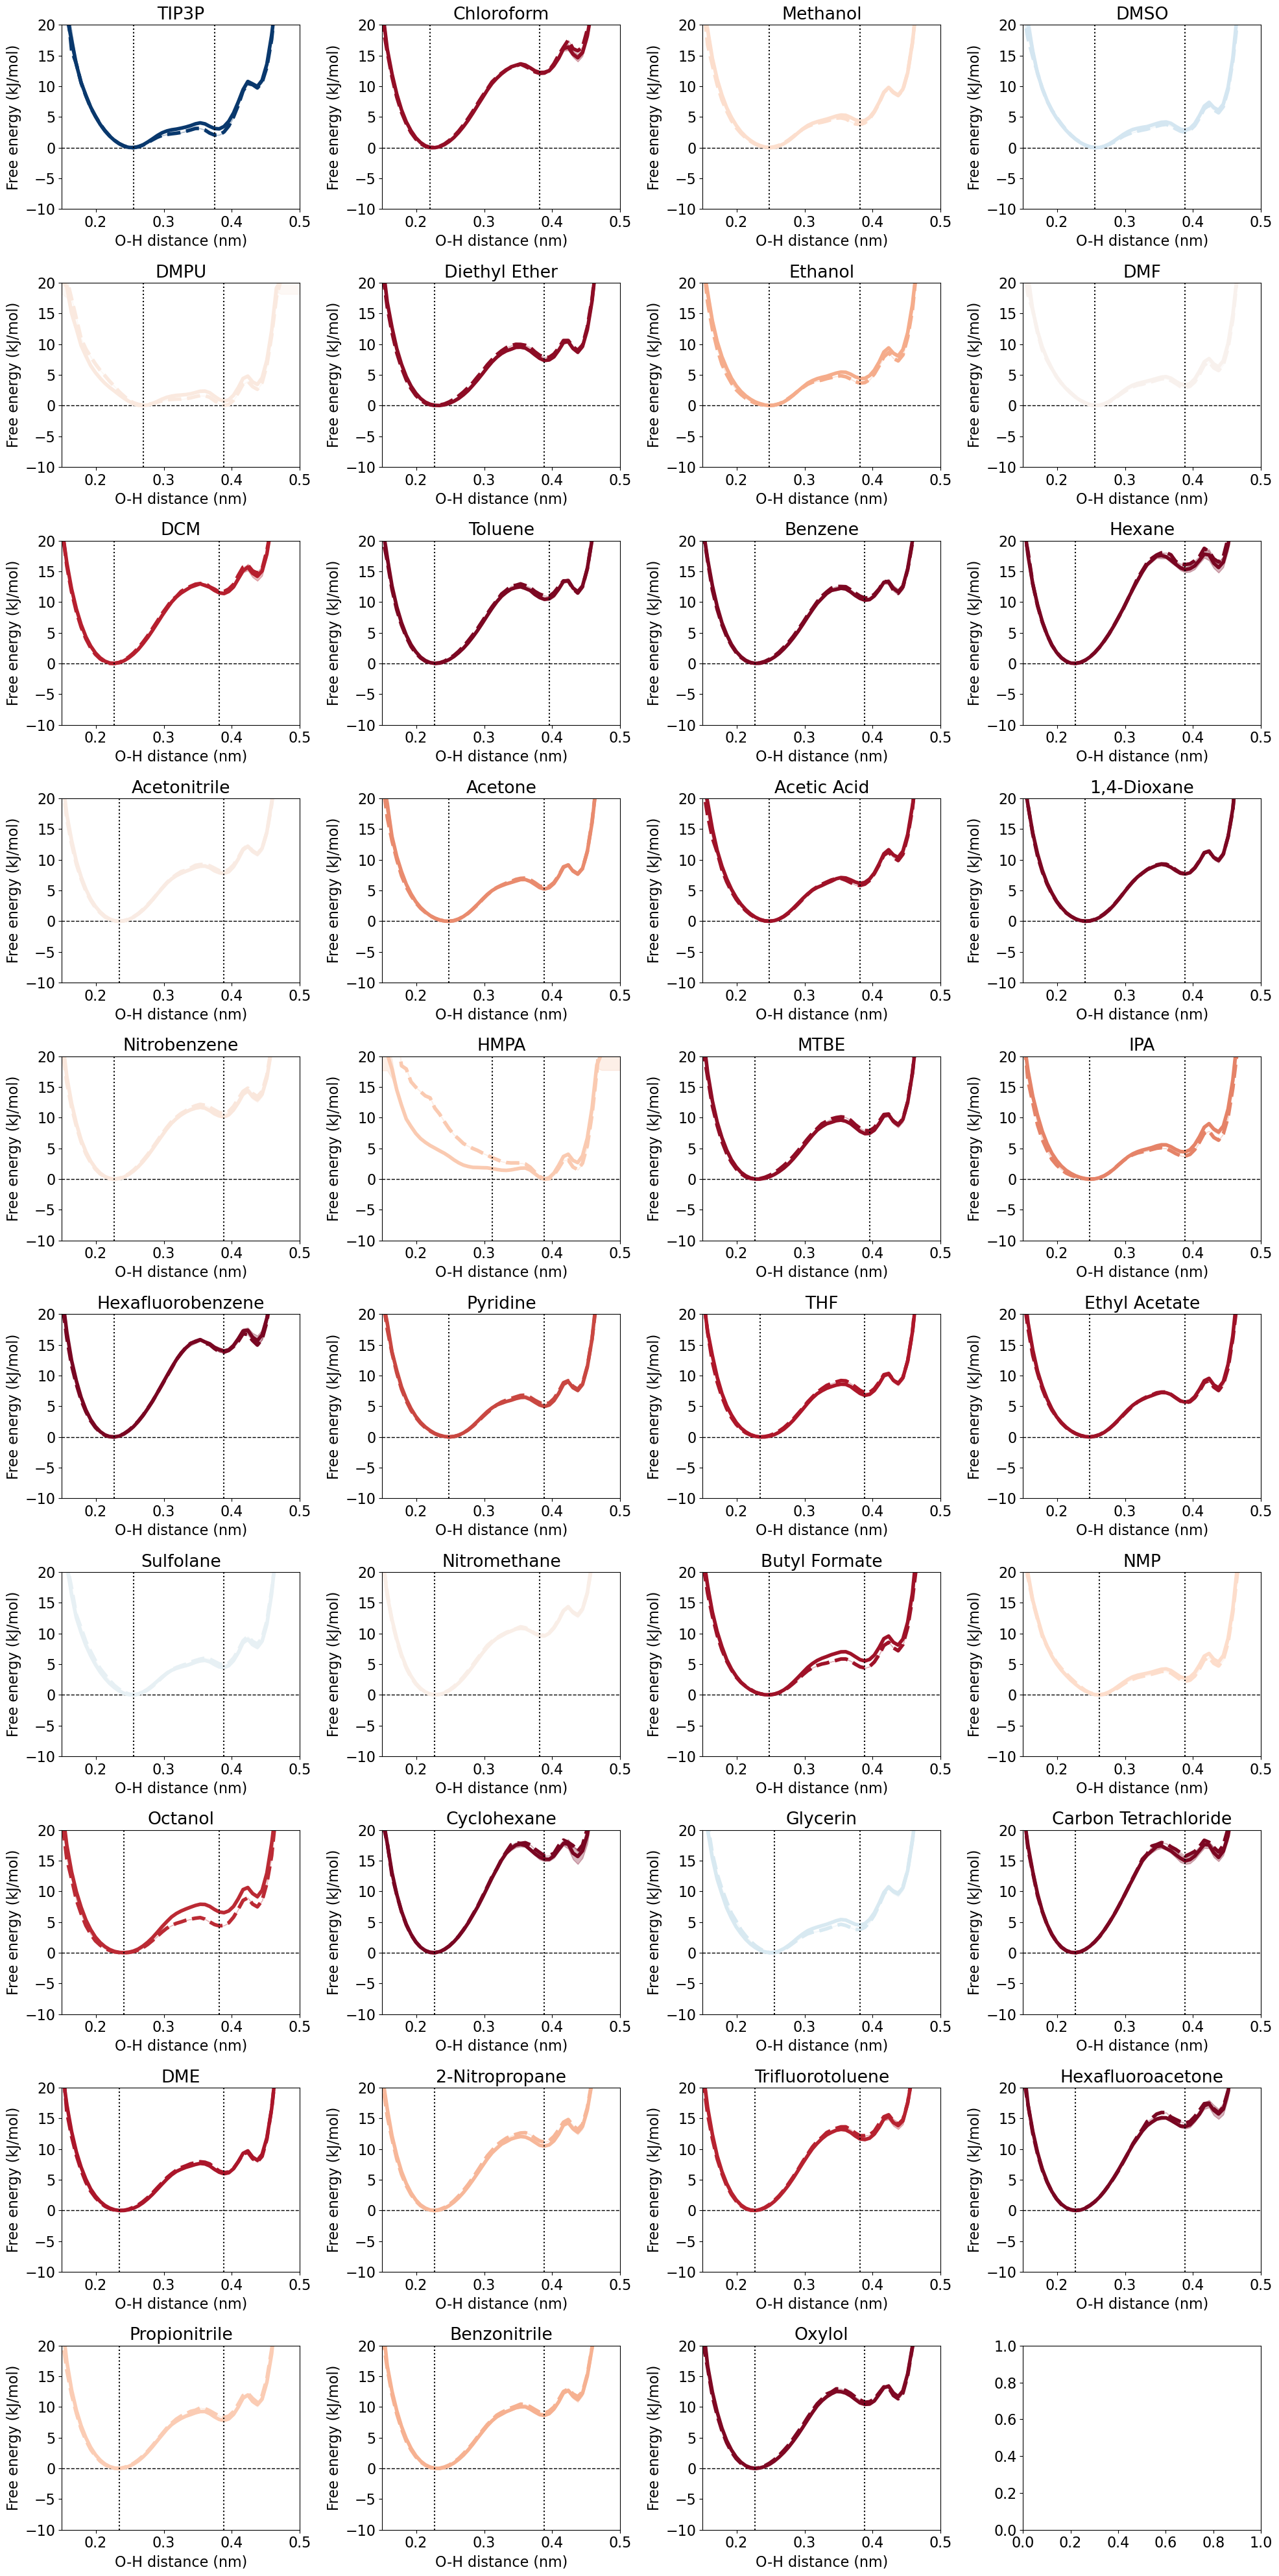

In [17]:
fig, axd = plt.subplot_mosaic([['plot_%i%i' % (i,j) for i in range(4)] for j in range(10)], figsize=(20, 40))


w2dis, w2intradis, kjmoldis, intrakjmoldis = {}, {}, {}, {}

for i, sn in enumerate(solvent_names):
    ax = axd['plot_%i%i' % (i%4,i//4)]
    gnn_dis = get_distance_by_name(gnn_trajs[sn], pair_dict[id][0], pair_dict[id][1])
    exp_dis = get_distance_by_name(explicit_trajs[sn], pair_dict[id][0], pair_dict[id][1])

    align_shifts_to = align_shift_dict[id]

    gx,gy,gstd_y = plot_free_energy(None,gnn_dis,nbins,(0,0.7),color='blue',label='TIP5P',ret_xz=True,linewidth=4)
    ex,ey,estd_y = plot_free_energy(None,np.array_split(exp_dis,3),nbins,(0,0.7),color='red',label='GBNeck2',ret_xz=True,linewidth=4)

    if id ==2:
        idx1, idx2 = 25, 75
    elif id == 1:
        idx1, idx2 = 27, 68
    elif id == 0:
        idx1, idx2 = 35, 55
        idx1 = np.argmin(ey)
        ax.set_xlim(0.15, 0.5)

    # select minima based on y values
    if id == 0:
        idx1 = np.argmin(ey[:45])
        idx2 = np.argmin(ey[50:]) + 50
    elif id == 1:
        idx1 = np.argmin(ey[:30])
        idx2 = np.argmin(ey[40:]) + 40
    elif id == 2:
        idx1 = np.argmin(ey[:30])
        idx2 = np.argmin(ey[40:]) + 40


    plot_ref_plus_pre(ax,exp_dis,gnn_dis,sn,align_shifts_to=align_shifts_to,linewidth=4)
    ax.set_xlabel('O-H distance (nm)')
    ax.set_ylabel('Free energy (kJ/mol)')
    ax.set_xlim(0.15, 0.7)
    if id == 0:
        ax.set_xlim(0.15, 0.5)
    ax.set_ylim(-10, 20)
    ax.set_title(solvent_dict[sn]["nice_name"])
    ax.hlines(0.0, 0.1, 0.8, color='black', linestyle='--', linewidth=1,zorder=0)


    w2dis[sn] = get_wasserstein_distance(exp_dis,gnn_dis,100,(0.1,0.7))
    w2intradis[sn] = get_wasserstein_distance(np.array_split(exp_dis,2)[0],np.array_split(exp_dis,2)[1],100,(0.1,0.7))

    
    ax.vlines(gx[idx1],-10,20,linestyles='dotted',colors='black')
    ax.vlines(gx[idx2],-10,20,linestyles='dotted',colors='black')

    gdif = gy[idx1]-gy[idx2]
    gdif_std = np.sqrt(gstd_y[idx1]**2+gstd_y[idx2]**2)

    edif = ey[idx1]-ey[idx2]
    edif_std = np.sqrt(estd_y[idx1]**2+estd_y[idx2]**2)

    kjmoldis[sn] = (gdif, gdif_std, edif, edif_std)
    

plt.tight_layout()
plt.show()

fig.savefig(f'{plot_folder}/SIPlots/intra_molecular_hbond2_all_solvents_id_%i_production_run_1612.pdf' % id, bbox_inches='tight')

In [18]:
DG_gnn = np.array([v[0] for k,v in kjmoldis.items()])
DG_std_gnn = np.array([v[1] for k,v in kjmoldis.items()])
DG_exp = np.array([v[2] for k,v in kjmoldis.items()])
DG_std_exp = np.array([v[3] for k,v in kjmoldis.items()])
solvent_dielectrics = np.array([float(solvent_dict[k]["dielectric"]) for k in kjmoldis.keys()])
import pickle
pickle.dump((DG_gnn, DG_std_gnn, DG_exp, DG_std_exp, solvent_dielectrics), open(f'{store_folder}intres_id_{id}_productionrun_1612.pkl', 'wb'))

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from scipy.stats import kendalltau

rmse = np.sqrt(mean_squared_error(DG_exp, DG_gnn))
mae = mean_absolute_error(DG_exp, DG_gnn)
Mae = median_absolute_error(DG_exp, DG_gnn)
correlation = np.corrcoef(DG_exp, DG_gnn)[0,1]
kendall_tau = kendalltau(DG_exp, DG_gnn)[0]

print(f"Root Mean squared error: {rmse}")
print(f"Mean absolute error: {mae}")
print(f"Median absolute error: {Mae}")
print(f"Correlation: {correlation}")
print(f"Kendall tau: {kendall_tau}")

Root Mean squared error: 0.6979683627327337
Mean absolute error: 0.5493870927485425
Median absolute error: 0.46250762632587517
Correlation: 0.9930302923869306
Kendall tau: 0.9379217273954116


In [ ]:
res0 = pickle.load(open(f'{store_folder}/intres_id_0_productionrun_1612.pkl', 'rb'))
res1 = pickle.load(open(f'{store_folder}/intres_id_1_productionrun_1612.pkl', 'rb'))
res2 = pickle.load(open(f'{store_folder}/intres_id_2_productionrun_1612.pkl', 'rb'))
res3 = pickle.load(open(f'{store_folder}dimethoxy_id_{0}_productionrun_1612.pkl', 'rb'))

res = (np.concatenate([res0[0],res1[0],res2[0],res3[0]]),np.concatenate([res0[1],res1[1],res2[1],res3[1]]),np.concatenate([res0[2],res1[2],res2[2],res3[2]]),np.concatenate([res0[3],res1[3],res2[3],res3[3]]),np.concatenate([res0[4],res1[4],res2[4],res3[4]]))

## Add if error higher than x show otherwise not

0.5531671372866644


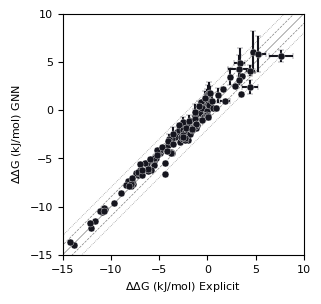

In [46]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["correlation"]],figsize=(3.25,3.25),tight_layout=True)

ax = axd['correlation']

# Exclude estimates with experimental errors larger than one kBT
res[2][res[3] > 2.5] = np.nan

# Dont plot errors smaller than 0.5 kJ/mol for clarity
res[3][res[3] < 0.5] = np.nan
res[1][res[1] < 0.5] = np.nan

print(np.nanmedian(np.abs(res[2] - res[0])))

ax.errorbar(res[2], res[0], xerr=res[3], yerr=res[1], fmt='o', c="#15151e", markeredgewidth=0.25, capsize=2, markeredgecolor="white",markersize=5)
ax.plot([-20,10],[-20,10],linestyle='-',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20+1,10+1],linestyle='--',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20+2,10+2],linestyle='dotted',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20-1,10-1],linestyle='--',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20-2,10-2],linestyle='dotted',color='grey',linewidth=0.5,zorder=0)
ax.set_ylim(-15,10)
ax.set_xlim(-15,10)
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\Delta\Delta$G (kJ/mol) Explicit')
ax.set_ylabel(r'$\Delta\Delta$G (kJ/mol) GNN')

fig.savefig(f'{plot_folder}/SIPlots/ddG_correlation.pdf', bbox_inches='tight')

# Special visualization of specific solvents

In [25]:
if id ==0:
    align_shifts_to = 0.381

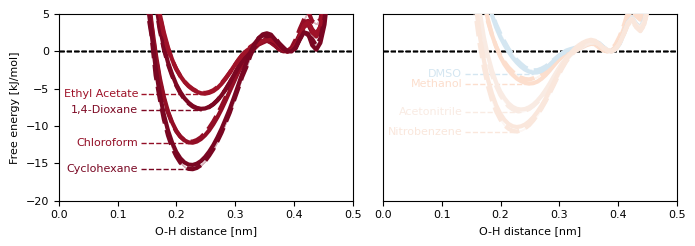

In [26]:
all_vis_solvents = [["Cyclohexane", "1,4-Dioxane", "Ethyl Acetate", "Chloroform"],["DMSO","Methanol","Acetonitrile","Nitrobenzene"]]


# set fontsize
plt.rcParams.update({'font.size': 8})

fig, axd = plt.subplot_mosaic([['plot_%i%i' % (i,j) for i in range(len(all_vis_solvents))] for j in range(1)], figsize=(7, 2.5))

# Set space between plots
plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.05)


w2dis, w2intradis, kjmoldis, intrakjmoldis = {}, {}, {}, {}

for k,vis_solvents in enumerate(all_vis_solvents):
    ax = axd['plot_%i%i' % (k,0)]
    for i, sn in enumerate(gnn_solvents):
        if not solvent_dict[sn]["nice_name"] in vis_solvents:
            continue

        gnn_dis = get_distance_by_name(gnn_trajs[sn], pair_dict[id][0], pair_dict[id][1])
        exp_dis = get_distance_by_name(explicit_trajs[sn], pair_dict[id][0], pair_dict[id][1])

        # plot_ref_plus_pre(ax,exp_dis,np.concatenate(gnn_dis),sn,align_shifts_to=align_shifts_to)
        zorder = 3
        

        gx,gy,gstd_y = plot_free_energy(None,gnn_dis,nbins,(0,0.7),color='blue',label='TIP5P',ret_xz=True)
        ex,ey,estd_y = plot_free_energy(None,np.array_split(exp_dis,3),nbins,(0,0.7),color='red',label='GBNeck2',ret_xz=True)

        index = np.argmin(np.abs(gx-align_shifts_to))
        mean_g_y = gy - gy[index] # static shift
        index = np.argmin(np.abs(ex-align_shifts_to))
        mean_e_y = ey - ey[index] # static shift
        
        hpos = np.min(np.concatenate((mean_g_y,mean_e_y)))
        if solvent_dict[sn]["nice_name"] == "DCM":
            hpos +=0.1

        if id ==2:
            idx1, idx2 = 25, 75
        elif id == 1:
            idx1, idx2 = 27, 68
        elif id == 0:
            idx1, idx2 = 35, 55
            idx1 = np.argmin(ey)
        
            # select minima based on y values
        if id == 0:
            idx1 = np.argmin(ey[:45])
            idx2 = np.argmin(ey[50:]) + 50

        align_shifts_to = ex[idx2]

        plot_ref_plus_pre(ax,exp_dis,np.concatenate(gnn_dis),sn,align_shifts_to=align_shifts_to,zorder=zorder,linewidth=3)


        ax.set_xlabel('O-H distance [nm]')
        ax.set_ylabel('Free energy [kJ/mol]')
        ax.set_xlim(0, 0.6)
        ax.set_ylim(-10, 10)
        if id == 0:
            ax.set_ylim(-20, 5)
            ax.set_xlim(0, 0.5)
        ax.hlines(0.0, 0, 0.525, color='black', linestyle='--', linewidth=1,zorder=0)

        w2dis[sn] = get_wasserstein_distance(exp_dis,gnn_dis,100,(0.1,0.7))
        w2intradis[sn] = get_wasserstein_distance(np.array_split(exp_dis,2)[0],np.array_split(exp_dis,2)[1],100,(0.1,0.7))



        if id == 0:
            ax.hlines(hpos, 0.14, ex[idx1], color=get_sd(sn), linestyle='--', linewidth=1,zorder=0)
        else:
            ax.hlines(hpos, 0.14, ex[idx1], color=get_sd(sn), linestyle='--', linewidth=1,zorder=0)
        ax.text(0.135, hpos, solvent_dict[sn]["nice_name"], color=get_sd(sn),ha='right',va='center')




        # ax.vlines(gx[idx1],-10,20,linestyles='dotted',colors='black')
        # ax.vlines(gx[idx2],-10,20,linestyles='dotted',colors='black')

        gdif = gy[idx1]-gy[idx2]
        gdif_std = np.sqrt(gstd_y[idx1]**2+gstd_y[idx2]**2)

        edif = ey[idx1]-ey[idx2]
        edif_std = np.sqrt(estd_y[idx1]**2+estd_y[idx2]**2)

        kjmoldis[sn] = (gdif, gdif_std, edif, edif_std)

ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

fig.savefig(f'{plot_folder}/intra_molecular_hbond_special_{i}_productionrun_1612.pdf', bbox_inches='tight')

# Dimethoxy

In [5]:
gnn_trajs = None
explicit_trajs = None

In [ ]:
folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/trajectories/dimethoxy/"

solvent_names = solvent_dict.keys()
explicit_trajs = {}

id = 0

for seed in [1613111,1613112,1613113]:
    for sn in solvent_names:
        try:
            if sn == "tip3p":
                traj = mdtraj.load(folder+f'dimethoxy{sn}{seed}_id_{id}_openff200_tip3p_0_{seed}_output_stripped.h5')
            else:
                traj = mdtraj.load(folder+f'dimethoxy{sn}{seed}_id_{id}_openff200_{solvent_dict[sn]["SMILES"]}_0_{seed}_output_stripped.h5')
            assert traj.n_frames == 250000

            if sn in explicit_trajs:
                explicit_trajs[sn] += traj
            else:
                explicit_trajs[sn] = traj

        except Exception as e:
            print(sn,e)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [7]:
gnn_solvents = "tip3p Chloroform Methanol DMSO DMPU Diethylether Ethanol DMF DCM Toluol Benzol Hexan acetonitrile acetone aceticacid 14dioxane nitrobenzol HMPA MTBE IPA Hexafluorobenzene pyridine THF Ethylacetate Sulfolane nitromethane Butylformate Octanol cyclohexane glycerin carbontetrachloride DME 2Nitropropane Trifluorotoluene hexafluroacetone Propionitrile Benzonitrile oxylol".split(" ")
num_solvents = len(gnn_solvents)
file_location = folder+"/../dimethoxy_multi_10_all_solvent_run_seed_1612/"

id_to_smiles_dict = {0:'COCCOC'}

traj_s = load_parallel_traj(file_location + 'dimethoxy_id_0_openff200_vacuum_plus_GNN3_vap_0_0_output.h5',num_solvents*10)

gnn_trajs = {}
for i, s in enumerate(gnn_solvents):
    gnn_trajs[s] = [traj_s[j*num_solvents+i] for j in range(len(traj_s)//num_solvents)]
del traj_s

file_location = folder+"/../dimethoxy_multi_10_NMP_solvent_run_seed_1612/"
gnn_trajs["NMP"] = load_parallel_traj(file_location + 'dimethoxy_id_0_openff200_vacuum_plus_GNN3_vap_0_0_output.h5',10)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [57]:
def plot_colorbar(ax,cmap,label):
    norm = plt.Normalize(vmin=0, vmax=80)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.set_label(label)

align_shifts_to = None
nbins = 100

def plot_ref_plus_pre(ax,ref,pre,solvent_name,align_shifts_to=None,zorder=1, use_jakobian_correction=True,range=(0,0.7),linewidth=2.5):

    plot_free_energy(ax, ref, nbins, label=solvent_name + ' (ref)', color=get_sd(solvent_name), range=range,linestyle='--',align_shifts_to=align_shifts_to,zorder=zorder, use_jakobian_correction=use_jakobian_correction,linewidth=linewidth)
    plot_free_energy(ax, pre, nbins, label=solvent_name, color=get_sd(solvent_name), range=range,align_shifts_to=align_shifts_to,zorder=zorder, use_jakobian_correction=use_jakobian_correction,linewidth=linewidth)

def get_sd(solvent_name):
    sd = solvent_dict[solvent_name]["dielectric"]
    return cm.RdBu(sd/80)

In [9]:
pair_dict = {0:('O1','O2')}

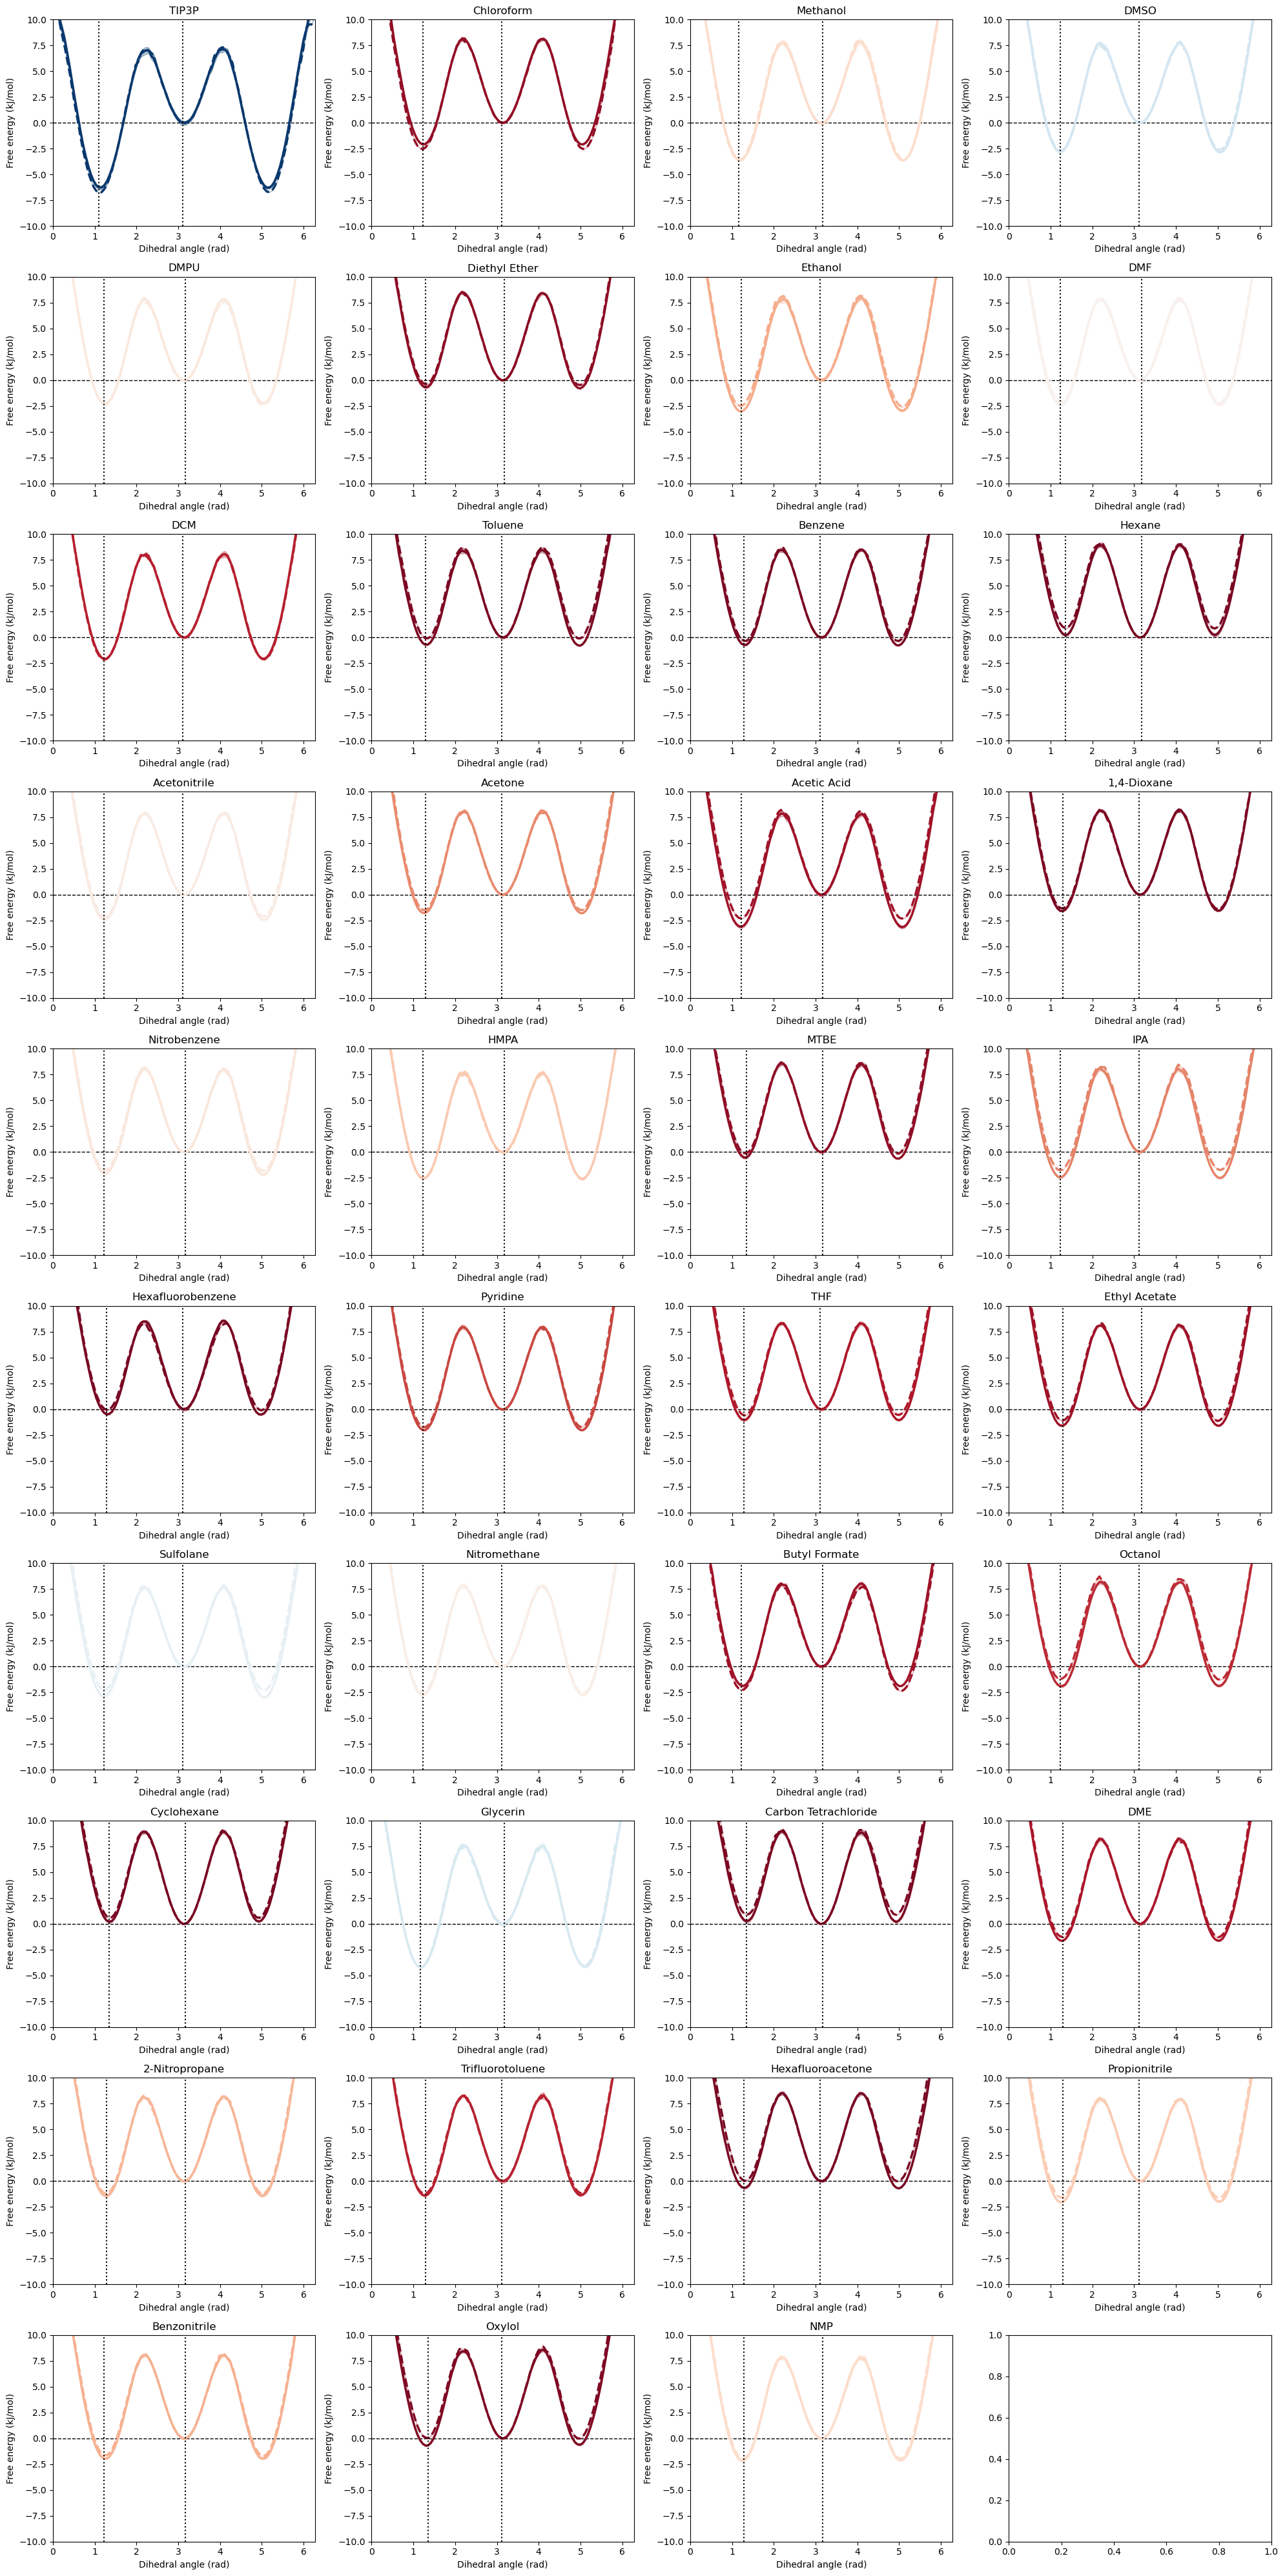

In [15]:
fig, axd = plt.subplot_mosaic([['plot_%i%i' % (i,j) for i in range(4)] for j in range(10)], figsize=(20, 40))

w2dis, w2intradis, kjmoldis, intrakjmoldis = {}, {}, {}, {}

align_shifts_to = np.pi

for i, sn in enumerate(gnn_trajs.keys()):
    # if sn == "tip5p_all":
    #     continue
    ax = axd['plot_%i%i' % (i%4,i//4)]

    gnn_dis = get_dihedrals_by_name(gnn_trajs[sn], *("O1 C2 C3 O2".split()))
    exp_dis = get_dihedrals_by_name(explicit_trajs[sn], *("O1 C2 C3 O2".split()))


    def shift_d(x):
        x[x<0] += 2*np.pi
        return x

    gnn_dis = [shift_d(d) for d in gnn_dis]
    exp_dis[exp_dis < 0] += 2*np.pi

    # gnn_dis = get_distance_by_name(gnn_trajs[sn], pair_dict[id][0], pair_dict[id][1])
    # exp_dis = get_distance_by_name(explicit_trajs[sn], pair_dict[id][0], pair_dict[id][1])

    plot_ref_plus_pre(ax,exp_dis,gnn_dis,sn,align_shifts_to=align_shifts_to,use_jakobian_correction=False, range=(0,2*np.pi))
    ax.set_xlabel('Dihedral angle (rad)')
    ax.set_ylabel('Free energy (kJ/mol)')
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-10, 10)
    ax.set_title(solvent_dict[sn]["nice_name"])
    ax.hlines(0.0, 0, 2*np.pi, color='black', linestyle='--', linewidth=1,zorder=0)


    w2dis[sn] = get_wasserstein_distance(exp_dis,gnn_dis,100,(0.1,0.7))
    w2intradis[sn] = get_wasserstein_distance(np.array_split(exp_dis,2)[0],np.array_split(exp_dis,2)[1],100,(0.1,0.7))

    
    gx,gy,gstd_y = plot_free_energy(None,gnn_dis,nbins,(0,2*np.pi),color='blue',label='TIP5P',ret_xz=True,use_jakobian_correction=False)
    ex,ey,estd_y = plot_free_energy(None,np.array_split(exp_dis,3),nbins,(0,2*np.pi),color='red',label='GBNeck2',ret_xz=True,use_jakobian_correction=False)


    
        # select minima based on y values

    idx1 = np.argmin(ey[:33])
    idx2 = np.argmin(ey[33:66]) + 33


    ax.vlines(gx[idx1],-10,20,linestyles='dotted',colors='black')
    ax.vlines(gx[idx2],-10,20,linestyles='dotted',colors='black')

    gdif = gy[idx1]-gy[idx2]
    gdif_std = np.sqrt(gstd_y[idx1]**2+gstd_y[idx2]**2)

    edif = ey[idx1]-ey[idx2]
    edif_std = np.sqrt(estd_y[idx1]**2+estd_y[idx2]**2)

    kjmoldis[sn] = (gdif, gdif_std, edif, edif_std)

plt.tight_layout()
plt.show()

fig.savefig(f'{plot_folder}/SIPlots/dimethoxy_all_solvents_id_%i_production_run_1612.pdf' % id, bbox_inches='tight')

In [17]:
DG_gnn = np.array([v[0] for k,v in kjmoldis.items()])
DG_std_gnn = np.array([v[1] for k,v in kjmoldis.items()])
DG_exp = np.array([v[2] for k,v in kjmoldis.items()])
DG_std_exp = np.array([v[3] for k,v in kjmoldis.items()])
solvent_dielectrics = np.array([float(solvent_dict[k]["dielectric"]) for k in kjmoldis.keys()])

In [18]:
import pickle
pickle.dump((DG_gnn, DG_std_gnn, DG_exp, DG_std_exp, solvent_dielectrics), open(f'{store_folder}dimethoxy_id_{id}_productionrun_1612.pkl', 'wb'))

# Comparison of GBNeck2

## Intra molecular hydrogen bonds

In [33]:
additional_submission_string = ""
import pickle

In [34]:
id_to_smiles_dict = {0:'COCCO',1:'COCCCO',2:'COCCCCO'}

In [35]:
## read in reference distances
store_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/intermediary_results/"
gbneck_2_distances = pickle.load(open(f'{store_folder}I1I2I3_distance.pkl', 'rb'))

In [36]:
gbneck_2_distances[0].keys()

dict_keys([2.4, 2.0, 38.2, 7.5, 2.2, 36.6, 4.3, 6.2, 29.6, 2.6, 4.5, 25.9, 47.2, 6.1, 4.8, 35.6, 29.7, 46.5, 9.2, 21.0, 20.2, 1.9, 78.5, 43.3, 33.0, 13.3, 7.3, 25.3, 36.1, 32.5, 37.3, 2.3, 26.7, 8.9, 10.3, 2.1])

In [48]:
id = 2

In [49]:
align_shifts_to = align_shift_dict[id]

In [ ]:

folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/trajectories/intra_molecular_hbond2/"

solvent_names = solvent_dict.keys()
explicit_trajs = {}

for sn in solvent_names:
    if sn == "tip3p":
        for seed in [1613111,1613112,1613113]:
            try:
                traj = mdtraj.load(f'{folder}/intra_molecular_hbond2_id_%i_openff200_tip3p_0_%i_output_stripped.h5' % (id,seed))
                assert traj.n_frames == 250000
                if seed == 1613111:
                    explicit_trajs[sn] = traj
                else:
                    explicit_trajs[sn] += traj
            except Exception as e:
                print(e)
                print(sn,seed)
    else:
        for seed in [1613111,1613112,1613113]:
            try:
                if os.path.isfile(f'{folder}/intra_molecular_hbond2{sn}{seed}_id_%i_openff200_%s_0_%i_output_stripped.h5' % (id, solvent_dict[sn]["SMILES"],seed)):
                    traj = mdtraj.load(f'{folder}/intra_molecular_hbond2{sn}{seed}_id_%i_openff200_%s_0_%i_output_stripped.h5' % (id, solvent_dict[sn]["SMILES"],seed))
                else:
                    traj = mdtraj.load(f'{folder}/intra_molecular_hbond2_id_%i_openff200_%s_0_%i_output_stripped.h5' % (id, solvent_dict[sn]["SMILES"],seed))
                assert traj.n_frames == 250000
                if seed == 1613111:
                    explicit_trajs[sn] = traj
                else:
                    explicit_trajs[sn] += traj
            except Exception as e:
                print(e)
                print(sn,seed)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


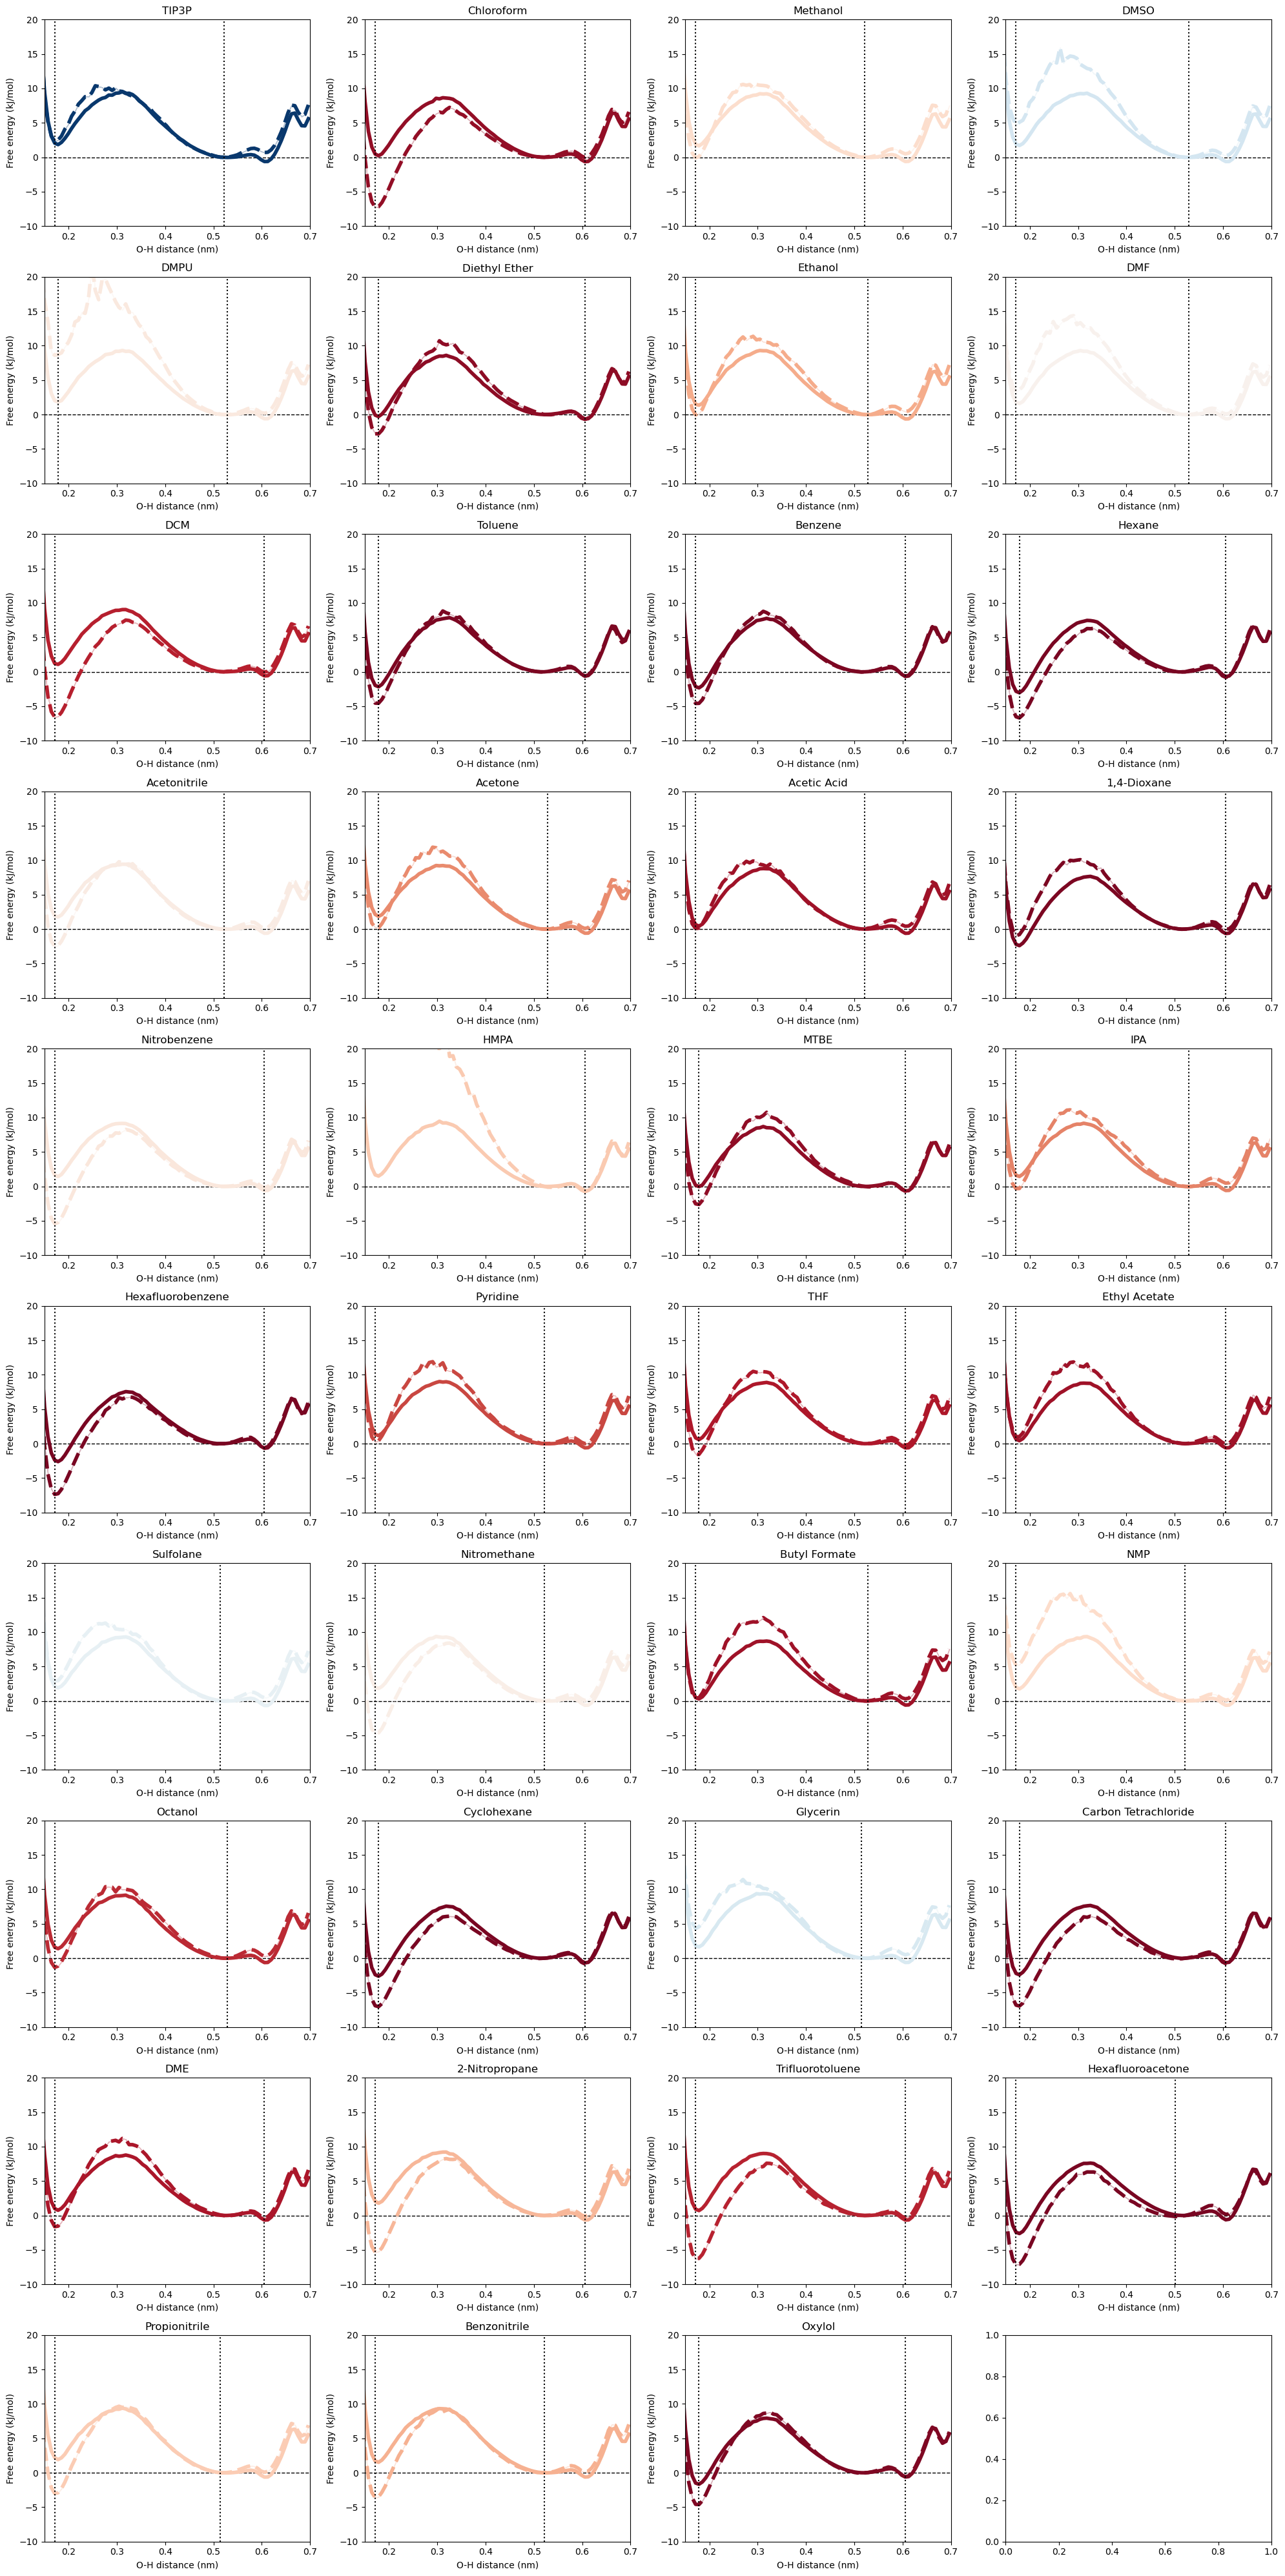

In [51]:
fig, axd = plt.subplot_mosaic([['plot_%i%i' % (i,j) for i in range(4)] for j in range(10)], figsize=(20, 40))

w2dis, w2intradis, kjmoldis, intrakjmoldis = {}, {}, {}, {}

for i, sn in enumerate(solvent_names):
    ax = axd['plot_%i%i' % (i%4,i//4)]
    try:
        gbneck2_dis = gbneck_2_distances[id][float("%.1f" % solvent_dict[sn]['dielectric'])]
    except:
        additional_submission_string += f"""
sbatch --array={id} -n 8 --gpus=1 --time=24:00:00  --mem-per-cpu=2000 -o simulation/slurm_log/production_run_sim_gbneck_%A_%a.out --wrap='python run_simulation_for_small_molecules.py -id $SLURM_ARRAY_TASK_ID -n 1000 -f simulation_smiles/intra_molecular_hbond2.txt -s GBNeck2 -r 161311 -sd {solvent_dict[sn]['dielectric']} -i 100 -ad "gbneck2_production"'"""
        continue
    exp_dis = get_distance_by_name(explicit_trajs[sn], pair_dict[id][0], pair_dict[id][1])

    align_shifts_to = align_shift_dict[id]

    gx,gy,gstd_y = plot_free_energy(None,gbneck2_dis,nbins,(0,0.7),color='blue',label='TIP5P',ret_xz=True,linewidth=4)
    ex,ey,estd_y = plot_free_energy(None,np.array_split(exp_dis,3),nbins,(0,0.7),color='red',label='GBNeck2',ret_xz=True,linewidth=4)

    if id ==2:
        idx1, idx2 = 25, 75
    elif id == 1:
        idx1, idx2 = 27, 68
    elif id == 0:
        idx1, idx2 = 35, 55
        idx1 = np.argmin(ey)
        ax.set_xlim(0.15, 0.5)

    # select minima based on y values
    if id == 0:
        idx1 = np.argmin(ey[:45])
        idx2 = np.argmin(ey[50:]) + 50
    elif id == 1:
        idx1 = np.argmin(ey[:30])
        idx2 = np.argmin(ey[40:]) + 40
    elif id == 2:
        idx1 = np.argmin(ey[:30])
        idx2 = np.argmin(ey[40:]) + 40


    plot_ref_plus_pre(ax,exp_dis,gbneck2_dis,sn,align_shifts_to=align_shifts_to,linewidth=4)
    ax.set_xlabel('O-H distance (nm)')
    ax.set_ylabel('Free energy (kJ/mol)')
    ax.set_xlim(0.15, 0.7)
    if id == 0:
        ax.set_xlim(0.15, 0.5)
    ax.set_ylim(-10, 20)
    ax.set_title(solvent_dict[sn]["nice_name"])
    ax.hlines(0.0, 0.1, 0.8, color='black', linestyle='--', linewidth=1,zorder=0)


    w2dis[sn] = get_wasserstein_distance(exp_dis,gbneck2_dis,100,(0.1,0.7))
    w2intradis[sn] = get_wasserstein_distance(np.array_split(exp_dis,2)[0],np.array_split(exp_dis,2)[1],100,(0.1,0.7))

    
    ax.vlines(gx[idx1],-10,20,linestyles='dotted',colors='black')
    ax.vlines(gx[idx2],-10,20,linestyles='dotted',colors='black')

    gdif = gy[idx1]-gy[idx2]
    gdif_std = np.sqrt(gstd_y[idx1]**2+gstd_y[idx2]**2)

    edif = ey[idx1]-ey[idx2]
    edif_std = np.sqrt(estd_y[idx1]**2+estd_y[idx2]**2)

    kjmoldis[sn] = (gdif, gdif_std, edif, edif_std)
    

plt.tight_layout()
plt.show()

fig.savefig(f'{plot_folder}/SIPlots/intra_molecular_hbond2_gbneck2_all_solvents_id_%i_production_run_1612.pdf' % id, bbox_inches='tight')

In [52]:
DG_gnn = np.array([v[0] for k,v in kjmoldis.items()])
DG_std_gnn = np.array([v[1] for k,v in kjmoldis.items()])
DG_exp = np.array([v[2] for k,v in kjmoldis.items()])
DG_std_exp = np.array([v[3] for k,v in kjmoldis.items()])
solvent_dielectrics = np.array([float(solvent_dict[k]["dielectric"]) for k in kjmoldis.keys()])
store_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/intermediary_results/"
import pickle
pickle.dump((DG_gnn, DG_std_gnn, DG_exp, DG_std_exp, solvent_dielectrics), open(f'{store_folder}intres_gbneck2_id_{id}_productionrun_1612.pkl', 'wb'))

### Dimethoxy

In [53]:
additional_submission_string = ""

In [54]:
## read in reference distances
store_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/intermediary_results/"
gbneck_2_distances = pickle.load(open(f'{store_folder}dimethoxy_dihedrals.pkl', 'rb'))
id = 0

In [ ]:
folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/trajectories/dimethoxy/"

solvent_names = solvent_dict.keys()
explicit_trajs = {}

id = 0

for seed in [1613111,1613112,1613113]:
    for sn in solvent_names:
        try:
            if sn == "tip3p":
                traj = mdtraj.load(folder+f'dimethoxy{sn}{seed}_id_{id}_openff200_tip3p_0_{seed}_output_stripped.h5')
            else:
                traj = mdtraj.load(folder+f'dimethoxy{sn}{seed}_id_{id}_openff200_{solvent_dict[sn]["SMILES"]}_0_{seed}_output_stripped.h5')
            assert traj.n_frames == 250000

            if sn in explicit_trajs:
                explicit_trajs[sn] += traj
            else:
                explicit_trajs[sn] = traj

        except Exception as e:
            print(sn,e)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


39it [00:06,  5.64it/s]


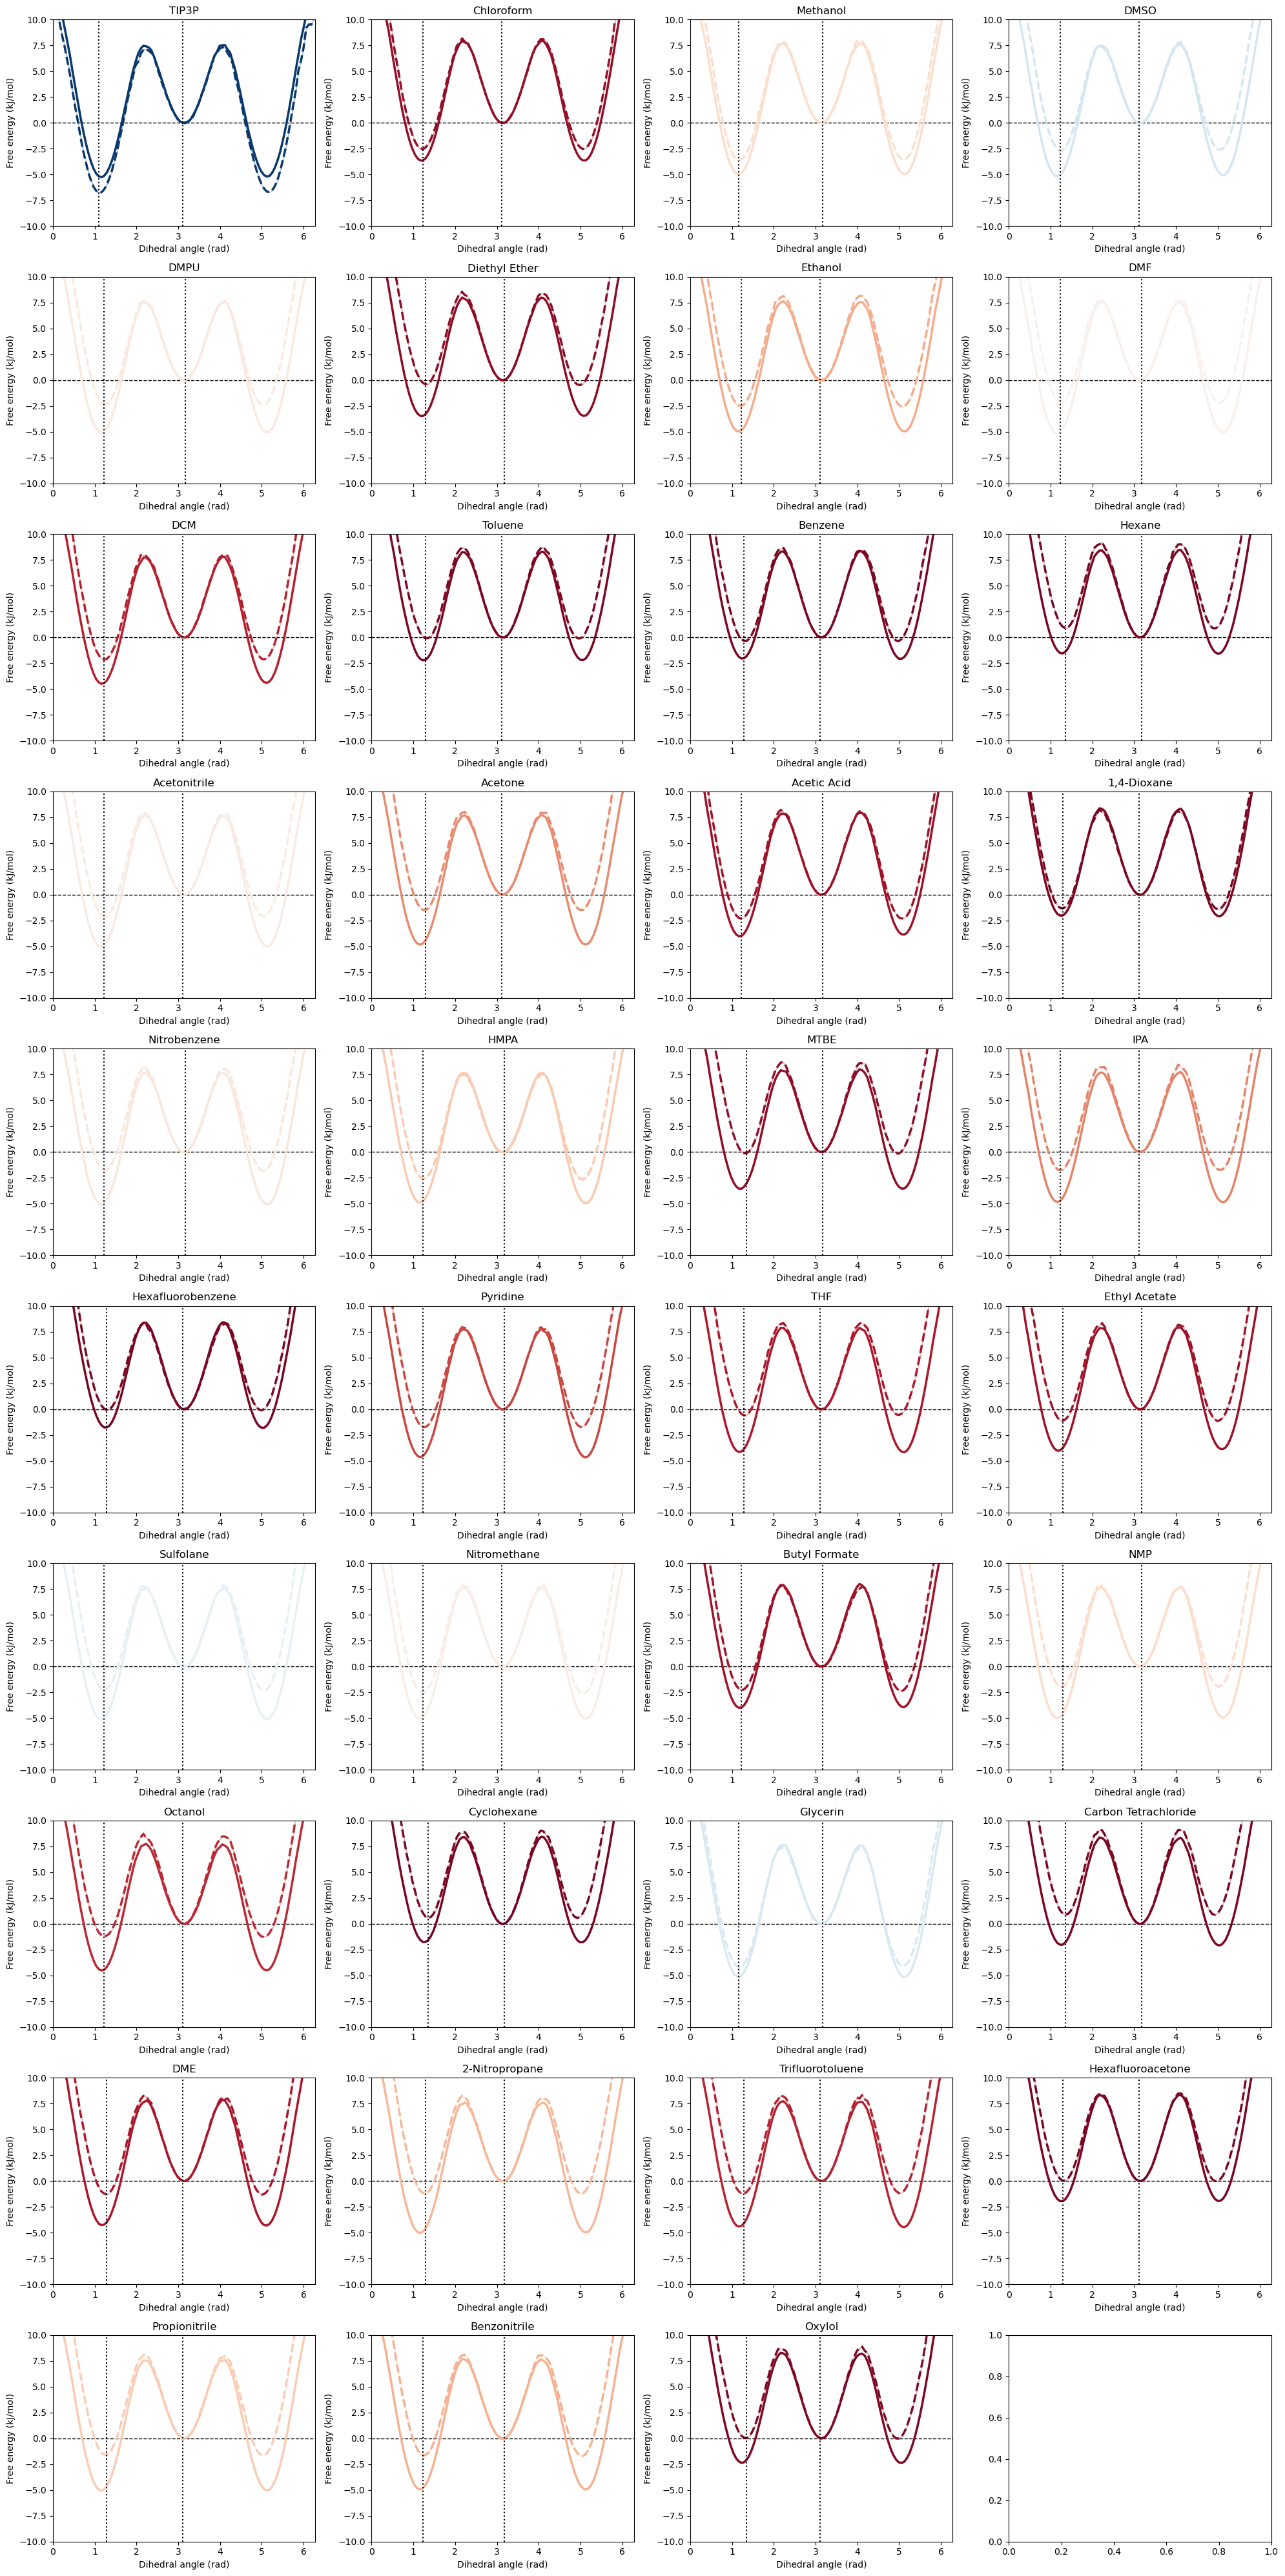

In [58]:
fig, axd = plt.subplot_mosaic([['plot_%i%i' % (i,j) for i in range(4)] for j in range(10)], figsize=(20, 40))

w2dis, w2intradis, kjmoldis, intrakjmoldis = {}, {}, {}, {}

align_shifts_to = np.pi

for i, sn in tqdm(enumerate(explicit_trajs.keys())):
    # if sn == "tip5p_all":
    #     continue
    ax = axd['plot_%i%i' % (i%4,i//4)]
    try:
        gbneck2_dis = [gbneck_2_distances[id][float("%.1f" % solvent_dict[sn]['dielectric'])]]
    except:
        additional_submission_string += f"""
sbatch --array={0} -n 8 --gpus=1 --time=24:00:00  --mem-per-cpu=2000 -o simulation/slurm_log/production_run_sim_gbneck_%A_%a.out --wrap='python run_simulation_for_small_molecules.py -id $SLURM_ARRAY_TASK_ID -n 1000 -f simulation_smiles/dimethoxy.txt -s GBNeck2 -r 161311 -sd {solvent_dict[sn]['dielectric']} -i 100 -ad "gbneck2_production"'"""
        continue
    exp_dis = get_dihedrals_by_name(explicit_trajs[sn], *("O1 C2 C3 O2".split()))

    def shift_d(x):
        x[x<0] += 2*np.pi
        return x

    gbneck2_dis = [shift_d(d) for d in gbneck2_dis]
    exp_dis[exp_dis < 0] += 2*np.pi

    # gbneck2_dis = get_distance_by_name(gnn_trajs[sn], pair_dict[id][0], pair_dict[id][1])
    # exp_dis = get_distance_by_name(explicit_trajs[sn], pair_dict[id][0], pair_dict[id][1])

    plot_ref_plus_pre(ax,exp_dis,gbneck2_dis,sn,align_shifts_to=align_shifts_to,use_jakobian_correction=False, range=(0,2*np.pi))
    ax.set_xlabel('Dihedral angle (rad)')
    ax.set_ylabel('Free energy (kJ/mol)')
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-10, 10)
    ax.set_title(solvent_dict[sn]["nice_name"])
    ax.hlines(0.0, 0, 2*np.pi, color='black', linestyle='--', linewidth=1,zorder=0)


    w2dis[sn] = get_wasserstein_distance(exp_dis,gbneck2_dis,100,(0.1,0.7))
    w2intradis[sn] = get_wasserstein_distance(np.array_split(exp_dis,2)[0],np.array_split(exp_dis,2)[1],100,(0.1,0.7))

    
    gx,gy,gstd_y = plot_free_energy(None,gbneck2_dis,nbins,(0,2*np.pi),color='blue',label='TIP5P',ret_xz=True,use_jakobian_correction=False)
    ex,ey,estd_y = plot_free_energy(None,np.array_split(exp_dis,3),nbins,(0,2*np.pi),color='red',label='GBNeck2',ret_xz=True,use_jakobian_correction=False)


    
        # select minima based on y values

    idx1 = np.argmin(ey[:33])
    idx2 = np.argmin(ey[33:66]) + 33


    ax.vlines(gx[idx1],-10,20,linestyles='dotted',colors='black')
    ax.vlines(gx[idx2],-10,20,linestyles='dotted',colors='black')

    gdif = gy[idx1]-gy[idx2]
    gdif_std = np.sqrt(gstd_y[idx1]**2+gstd_y[idx2]**2)

    edif = ey[idx1]-ey[idx2]
    edif_std = np.sqrt(estd_y[idx1]**2+estd_y[idx2]**2)

    kjmoldis[sn] = (gdif, gdif_std, edif, edif_std)

plt.tight_layout()
plt.show()

fig.savefig(f'{plot_folder}/SIPlots/dimethoxy_gbneck2_all_solvents_id_%i_production_run_1612.pdf' % id, bbox_inches='tight')

In [59]:
print(additional_submission_string)

In [60]:
DG_gnn = np.array([v[0] for k,v in kjmoldis.items()])
DG_std_gnn = np.array([v[1] for k,v in kjmoldis.items()])
DG_exp = np.array([v[2] for k,v in kjmoldis.items()])
DG_std_exp = np.array([v[3] for k,v in kjmoldis.items()])
solvent_dielectrics = np.array([float(solvent_dict[k]["dielectric"]) for k in kjmoldis.keys()])
store_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/intra_molecular_HBond/intermediary_results/"
import pickle
pickle.dump((DG_gnn, DG_std_gnn, DG_exp, DG_std_exp, solvent_dielectrics), open(f'{store_folder}dimethoxy_gbneck2_id_{id}_productionrun_1612.pkl', 'wb'))

In [61]:
res0 = pickle.load(open(f'{store_folder}/intres_gbneck2_id_0_productionrun_1612.pkl', 'rb'))
res1 = pickle.load(open(f'{store_folder}/intres_gbneck2_id_1_productionrun_1612.pkl', 'rb'))
res2 = pickle.load(open(f'{store_folder}/intres_gbneck2_id_2_productionrun_1612.pkl', 'rb'))
res3 = pickle.load(open(f'{store_folder}dimethoxy_gbneck2_id_{0}_productionrun_1612.pkl', 'rb'))
res = (np.concatenate([res0[0],res1[0],res2[0],res3[0]]),np.concatenate([res0[1],res1[1],res2[1],res3[1]]),np.concatenate([res0[2],res1[2],res2[2],res3[2]]),np.concatenate([res0[3],res1[3],res2[3],res3[3]]),np.concatenate([res0[4],res1[4],res2[4],res3[4]]))

2.5446363182121465


/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


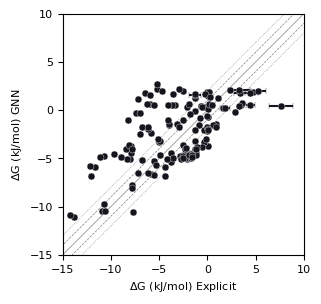

In [63]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["correlation"]],figsize=(3.25,3.25),tight_layout=True)

ax = axd['correlation']

# Exclude estimates with experimental errors larger than one kBT
res[2][res[3] > 2.5] = np.nan

# Dont plot errors smaller than 0.5 kJ/mol for clarity
res[3][res[3] < 0.5] = np.nan
res[1][res[1] < 0.5] = np.nan

print(np.nanmedian(np.abs(res[2] - res[0])))

ax.errorbar(res[2], res[0], xerr=res[3], yerr=res[1], fmt='o', c="#15151e", markeredgewidth=0.25, capsize=2, markeredgecolor="white",markersize=5)
ax.plot([-20,10],[-20,10],linestyle='-',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20+1,10+1],linestyle='--',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20+2,10+2],linestyle='dotted',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20-1,10-1],linestyle='--',color='grey',linewidth=0.5,zorder=0)
ax.plot([-20,10],[-20-2,10-2],linestyle='dotted',color='grey',linewidth=0.5,zorder=0)
ax.set_ylim(-15,10)
ax.set_xlim(-15,10)
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\Delta$G (kJ/mol) Explicit')
ax.set_ylabel(r'$\Delta$G (kJ/mol) GNN')

fig.savefig(f'{plot_folder}/SIPlots/ddG_gbneck2_correlation.pdf', bbox_inches='tight')